In [39]:
# turn to True if Andrea using notebook
andrea = True

In [ ]:
import pandas as pd
import ee
import geemap
import folium
from IPython.display import Image
import ipyleaflet # to show the map in the notebook
import math
from matplotlib import pyplot as plt

if andrea:

  from google.colab import drive
  drive.mount('/content/drive')

  import sys
  sys.path.insert(0,'/content/drive/MyDrive/src')
  from fishnet import Fishnet

else:

  import sys
  sys.path.append('../src')
  from fishnet import Fishnet

import warnings
warnings.filterwarnings('ignore')

if andrea:
  !pip --disable-pip-version-check --root-user-action=ignore install geemap
  !pip --disable-pip-version-check --root-user-action=ignore install geopandas
  !pip --disable-pip-version-check --root-user-action=ignore install imagecodecs

# update files automatically
%load_ext autoreload
%autoreload 2

## Packages required for using Dynamic World in a Jupyter Notebook

### How to install the EarthEngine Python package?

`EarthEngine`: 

Installation Tutorial: https://developers.google.com/earth-engine/guides/python_install-conda#mac_6

This tutorial requires the installation of Google Cloud: using the following command:
    
```bash
curl https://sdk.cloud.google.com | bash
```

To authenticate, you should: `earthengine authenticate` as the ee.Authenticate() function is not working. (it only works in Google Colab Notebooks)


### How to authenticate? 
Instructions are here: https://developers.google.com/earth-engine/cloud/earthengine_cloud_project_setup


### How to install the earthengine command-line tool in the Google Cloud Shell:
        
```bash
curl https://bootstrap.pypa.io/get-pip.py -o get-pip.py && python get-pip.py --user
pip install earthengine-api --upgrade --user
echo 'export PATH="$HOME/.local/bin:$PATH"' >> ~/.bashrc
source ~/.bashrc
```

You can validate this installation by using `earthengine authenticate` in the Google Cloud Shell.
            
- `GeeMap`: 


In [41]:
# useful for Andrea from Google Colab
if andrea:
  ee.Authenticate()

To authorize access needed by Earth Engine, open the following URL in a web browser and follow the instructions. If the web browser does not start automatically, please manually browse the URL below.

    https://code.earthengine.google.com/client-auth?scopes=https%3A//www.googleapis.com/auth/earthengine%20https%3A//www.googleapis.com/auth/devstorage.full_control&request_id=8yVok3LZvrrlunL23Uixzp-ddgtmTwMjosyGG6BWZ-g&tc=Pz-79PNTyiGdjiFCT6w_eEY6YNo9IZOSBgrNigCWDBU&cc=ikb-UBIMCbNSq9a8G93OICZETan4kYIQ0KA8U-X34AU

The authorization workflow will generate a code, which you should paste in the box below.
Enter verification code: 4/1AVHEtk58ZbfiZdgXiMZul2sNcYY_QkgJvYQ8PJeMtTvkF5YQS8pnPWyBxes

Successfully saved authorization token.


In [42]:
ee.Initialize(project="jpmorgancapstone")

### What are the bands?

The bands in the s2VisParams variable refer to the Sentinel-2 Harmonized dataset's specific bands used for visualization. Sentinel-2 data has 13 spectral bands, but we typically use a combination of three bands to visualize the data in RGB (red, green, blue) format. In this case, the bands used are:

'B4': The red band (band 4) with a central wavelength of 665 nm and a resolution of 10 meters.
'B3': The green band (band 3) with a central wavelength of 560 nm and a resolution of 10 meters.
'B2': The blue band (band 2) with a central wavelength of 490 nm and a resolution of 10 meters.
These three bands are used to create a true-color composite image that closely resembles how the human eye would perceive the landscape.

The min and max values in the s2VisParams are the minimum and maximum pixel values for visualization. These values are used to scale the brightness of the image. In this case, the pixel values are scaled between 0 and 3000, which is a common choice for Sentinel-2 data to enhance the contrast and improve the overall appearance of the image.

# Explore how to apply filters on Google Earth Engine

In [43]:
Map = geemap.Map()
Map.add_basemap('HYBRID')

In [69]:
# Set the region of interest by simply drawing a polygon on the map
region = Map.user_roi
bb_coords = [-96.8745,29.0542,-94.1144,30.6785]
if region is None:
    region = ee.Geometry.BBox(bb_coords[0],bb_coords[1],bb_coords[2],bb_coords[3])

rectangle = ee.Geometry.Rectangle(bb_coords)

Map.centerObject(region)

In [45]:
# Extract Dynamic World Data for year 2019
start_date = '2019-05-01'
end_date = '2019-09-01'

In [46]:
# Create a Sentinel-2 image composite
image = geemap.dynamic_world_s2(region, start_date, end_date)
vis_params = {'bands': ['B4', 'B3', 'B2'], 'min': 0, 'max': 3000}
Map.addLayer(image, vis_params, 'Sentinel-2 image')

In [47]:
Map1 = geemap.Map()
Map1.centerObject(region)
Map1.addLayer(image, vis_params, 'Sentinel-2 image')

In [48]:
# Create Dynamic World land cover composite
landcover = geemap.dynamic_world(region, start_date, end_date, return_type='probability')
Map1.addLayer(landcover, {}, 'Land Cover')

In [49]:
Map1

Map(center=[29.86635000086944, -95.49445], controls=(WidgetControl(options=['position', 'transparent_bg'], wid…

In [50]:
Map2 = geemap.Map()
Map2.centerObject(region)
#Map2.addLayer(image, vis_params, 'Sentinel-2 image')

In [51]:
# Create Dynamic World land cover composite
landcover = geemap.dynamic_world(region, start_date, end_date, return_type='hillshade')
Map2.addLayer(landcover, {}, 'Land Cover')

In [52]:
landcover

# plot the landcover image
#print(landcover)

In [53]:
# Add legend to the map
Map2.add_legend(title="Dynamic World Land Cover", builtin_legend='Dynamic_World')
Map2

Map(center=[29.86635000086944, -95.49445], controls=(WidgetControl(options=['position', 'transparent_bg'], wid…

In [54]:
landcover

In [55]:
Map3 = geemap.Map()
Map3.centerObject(region)

#Map3.addLayer(landcover, {}, 'Land Cover')

# Create a Dynamic World image collection
dw = ee.ImageCollection('GOOGLE/DYNAMICWORLD/V1') \
        .filterDate(start_date, end_date) \
        .filterBounds(region)

# Create a mode composite
classification = dw.select('label')
dwComposite = classification.reduce(ee.Reducer.mode())

# Extract the Built Area class
builtArea = dwComposite.eq(6)

# Define the visualization parameters
dwVisParams = {
    'min': 0,
    'max': 8,
    'palette': [
        '#419BDF', '#397D49', '#88B053', '#7A87C6', '#E49635', '#DFC35A',
        '#C4281B', '#A59B8F', '#B39FE1'
    ]
}

# Clip the composite and add it to the map
Map3.addLayer(dwComposite.clip(region), dwVisParams, 'Classified Composite')
Map3.addLayer(builtArea.clip(region), {}, 'Built Areas')

Map3.add_legend(title="Dynamic World Land Cover", builtin_legend='Dynamic_World')

# Rename the bands
dwComposite = dwComposite.rename(['classification'])
builtArea = builtArea.rename(['built_area'])

# Display the map
Map3

Map(center=[20, 0], controls=(WidgetControl(options=['position', 'transparent_bg'], widget=HBox(children=(Togg…

# ISSUE HERE: HOW TO EXPORT BLACK AND WHITE INSTEAD OF THE COLORED VERSION WITH ALL THE LABELS

In [70]:
# export this map to drive

#Extract a satellite image
image = geemap.dynamic_world_s2(region, start_date, end_date)

#Extract the Dynamic World Labels
landcover = geemap.dynamic_world(region, start_date, end_date, return_type='visualize')


# add bounding box that we extract to the map
Map3.addLayer(rectangle, {}, 'Bounding Box')

# Get the coordinates of the bounding box
coords = region.getInfo()['coordinates'][0]

# resolution in meters per pixel
res = 10

# Calculate the width and height of the bounding box in meters
width = ee.Geometry.Point(coords[0]).distance(ee.Geometry.Point(coords[1]))
height = ee.Geometry.Point(coords[1]).distance(ee.Geometry.Point(coords[2]))

# Print the width and height
print('Bounding Box Width:', width.getInfo(), 'meters')
print('Bounding Box Height:', height.getInfo(), 'meters')

# If 10m is one pixel, total number of required pixel in the image (witdh and height):
print('Image width (pixels): ', math.ceil(width.getInfo() / res))
print('Image height (pixels): ', math.ceil(height.getInfo() / res))
print("Total number of pixels: ", math.ceil(width.getInfo() / res) * math.ceil(height.getInfo() / res))

### Save the image
export_params = {
    'image': landcover,
    'description': 'land_labels_test_export_build_notbuilt',
    'folder': '/ge_exports/',  # Google Drive folder name
    'scale': 10,  # Resolution in meters
    'region': region,
    'fileFormat': 'GeoTIFF',
    'maxPixels': 1e10,  # Increase this value if you encounter an error due to the pixel limit
}

export_task = ee.batch.Export.image.toDrive(**export_params)
export_task.start()


Bounding Box Width: 268794.68572622666 meters
Bounding Box Height: 180054.83789302458 meters
Image width (pixels):  26880
Image height (pixels):  18006
Total number of pixels:  484001280


In [56]:
Map4 = geemap.Map()

Map4.centerObject(region)

# Clip the composite and add it to the map
Map4.addLayer(dwComposite.clip(region), dwVisParams, 'Classified Composite')
Map4.addLayer(builtArea.clip(region), {}, 'Built Areas')

fishnet = geemap.fishnet(region, rows=6, cols=8, delta=0)

Map4.addLayer(fishnet, {}, 'Fishnet')

mean_image = image.reduceRegions(fishnet, ee.Reducer.mean())

# Add the mean image as a layer to the map
Map4.addLayer(mean_image, {}, 'Mean Image')

Map4

# STILL DON'T KNOW HOW TO EXTRACT THE AVERAGE VALUE OF THE PIXELS IN EACH SQUARE, will do later in the notebook

Map(center=[20, 0], controls=(WidgetControl(options=['position', 'transparent_bg'], widget=HBox(children=(Togg…

In [57]:
mean_image

## Test - Matrix Extraction

### Image extraction from the Google Earth Engine

In [3]:
#Parameters
bb_coords = [-95.799944,29.374853,-95.028636,29.795492]
region = ee.Geometry.BBox(bb_coords[0], bb_coords[1], bb_coords[2], bb_coords[3])
rectangle = ee.Geometry.Rectangle(bb_coords)

startDate = '2019-05-01'
endDate = '2019-09-01'

#Initialize the map
Map = geemap.Map()
Map.add_basemap('HYBRID')
Map.centerObject(region)
Map

Map(center=[20, 0], controls=(WidgetControl(options=['position', 'transparent_bg'], widget=HBox(children=(Togg…

In [4]:
#Extract a satellite image
image = geemap.dynamic_world_s2(region, startDate, endDate)

#Extract the Dynamic World Labels
landcover = geemap.dynamic_world(region, startDate, endDate, return_type='visualize')

#Add to map
Map.addLayer(landcover, {}, 'Land Cover')

# add bounding box that we extract to the map
Map.addLayer(rectangle, {}, 'Bounding Box')

In [5]:
# Get the coordinates of the bounding box
coords = region.getInfo()['coordinates'][0]

# resolution in meters per pixel
res = 10

# Calculate the width and height of the bounding box in meters
width = ee.Geometry.Point(coords[0]).distance(ee.Geometry.Point(coords[1]))
height = ee.Geometry.Point(coords[1]).distance(ee.Geometry.Point(coords[2]))

# Print the width and height
print('Bounding Box Width:', width.getInfo(), 'meters')
print('Bounding Box Height:', height.getInfo(), 'meters')

# If 10m is one pixel, total number of required pixel in the image (witdh and height):
print('Image width (pixels): ', math.ceil(width.getInfo() / res))
print('Image height (pixels): ', math.ceil(height.getInfo() / res))
print("Total number of pixels: ", math.ceil(width.getInfo() / res) * math.ceil(height.getInfo() / res))

Bounding Box Width: 74882.54092823579 meters
Bounding Box Height: 46626.134124752236 meters
Image width (pixels):  7489
Image height (pixels):  4663
Total number of pixels:  34921207


In [6]:
### Save the image
export_params = {
    'image': landcover,
    'description': 'land_labels_test_export2',
    'folder': '/ge_exports/',  # Google Drive folder name
    'scale': 10,  # Resolution in meters
    'region': region,
    'fileFormat': 'GeoTIFF',
    'maxPixels': 1e10,  # Increase this value if you encounter an error due to the pixel limit
}

export_task = ee.batch.Export.image.toDrive(**export_params)
export_task.start()

#### Why do we get 648 images?

Yes, I understand why this query returns 648 images. The Sentinel-2 satellite system consists of two satellites (Sentinel-2A and Sentinel-2B), which together provide a revisit time of 5 days at the equator. The query you provided filters the Sentinel-2 Harmonized dataset for images within a specified date range (from January 1, 2019, to January 1, 2020) and region, and with a cloud cover percentage less than 35%.

In the given region and time period, 648 images satisfy these conditions. It is important to note that Sentinel-2 images are divided into granules or tiles, each covering a specific area on the Earth's surface. The query returns all the images of the specified region, which may include overlapping or adjacent granules. The total number of images returned may vary depending on the size of the region, the time period, and the cloud cover conditions.

# Create a fishnet

In [33]:
if andrea:
  fishnet_creator = Fishnet('/content/drive/MyDrive/Texas_State_Boundary/State.shp', 10)
else:
  fishnet_creator = Fishnet('../Gis/Texas_State_Boundary/State.shp', 10, overlay_method='union') # Victor

fishnet = fishnet_creator.create_fishnet()
fishnet.head()

100%|██████████| 63/63 [00:00<00:00, 354.45it/s]


Generating polygons...
Cliping fishinet to boundaries...
Success. Fishnet created.


,id,OBJECTID,FIPS,CREATE_USE,CMNT,SHAPE_Leng,SHAPE_Area,geometry
0,53,1,48,TPP,NaN,56.835385,65.729229,"POLYGON ((-97.50226 26.00656, -97.50226 25.894..."
1,54,1,48,TPP,NaN,56.835385,65.729229,"POLYGON ((-97.50226 26.00656, -97.33292 26.006..."
2,55,1,48,TPP,NaN,56.835385,65.729229,"POLYGON ((-97.33292 26.00656, -97.16359 26.006..."
3,56,1,48,TPP,NaN,56.835385,65.729229,"POLYGON ((-97.16359 26.00656, -97.15080 26.006..."
4,126,1,48,TPP,NaN,56.835385,65.729229,"POLYGON ((-98.34892 26.17589, -98.34892 26.153..."


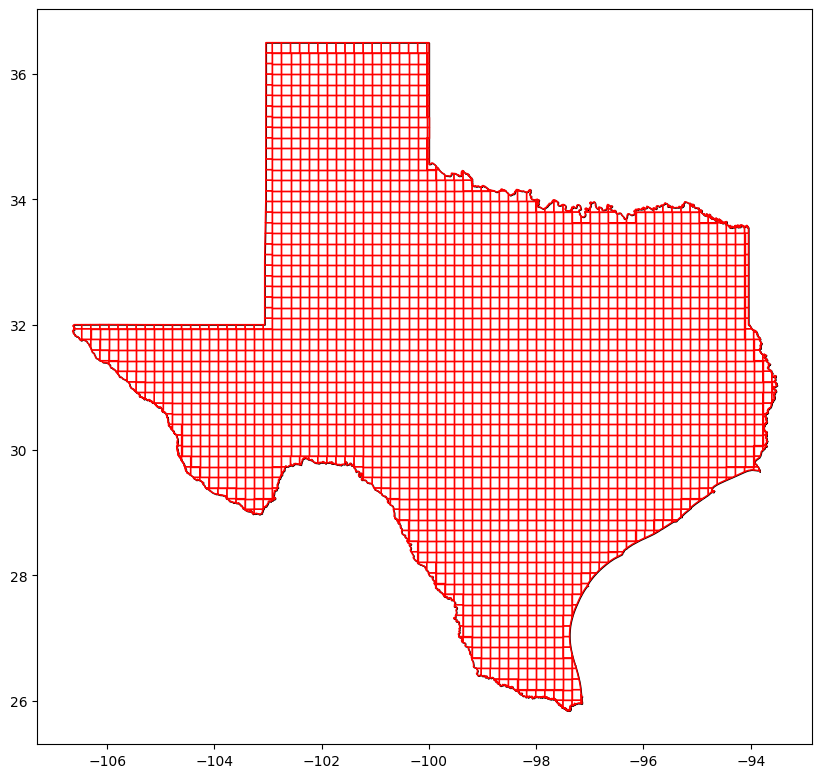

In [34]:
fishnet_creator.plot_fishnet()

# Read a TIFF Image in Python

Shape: (4683, 8588, 3)
Data type: uint8
Minimum value: 27
Maximum value: 228


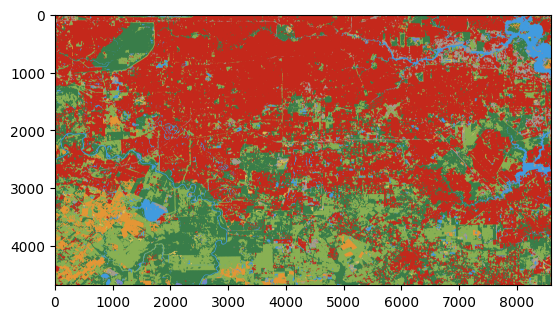

In [35]:
import imageio
import numpy as np

# Load the image
if andrea:
  image = imageio.imread('/content/drive/MyDrive/ ge_exports /land_labels_test_export2.tif') # for Andrea
else:
  image = imageio.imread('../Images/land_labels_test_export2.tif') # for Victor

# Print some information about the image
print('Shape:', image.shape)
print('Data type:', image.dtype)
print('Minimum value:', image.min())
print('Maximum value:', image.max())

#plot the image
plt.imshow(image)

## `[Work in progress...]` Extract probability values

In [63]:
dw = ee.ImageCollection('GOOGLE/DYNAMICWORLD/V1') \
        .filterDate(start_date, end_date) \
        .filterBounds(region)

dwImage = ee.Image(dw.first())

In [60]:
probabilityBands = [
  'water', 'trees', 'grass', 'flooded_vegetation', 'crops', 'shrub_and_scrub',
  'built', 'bare', 'snow_and_ice'
]

probabilityImage = dwImage.select(probabilityBands)

# Create the image with the highest probability value at each pixel.
top1Probability = probabilityImage.reduce(ee.Reducer.max())

In [61]:
top1Probability

## Extract density of 'built' in each region of the fishnet

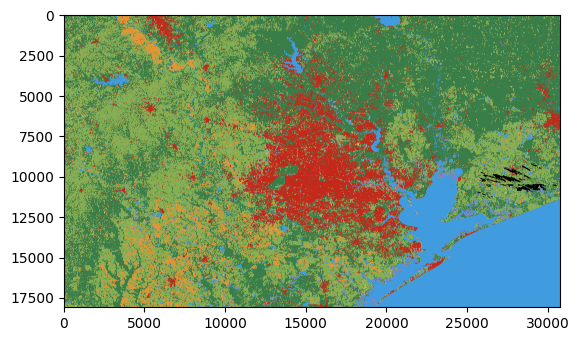

In [71]:
# Load the image
if andrea:
  image_bw = imageio.imread('/content/drive/MyDrive/ ge_exports /land_labels_test_export_build_notbuilt.tif')

plt.imshow(image_bw)

# ISSUE: DON'T KNOW WHY BUT EXPORTED RGB PICTURE, I THOUGHT THE MASK WITH BLACK AND WHITE WAS SUCCESSFULLY APPLIED. TO EXPLORE FURTHER

In [72]:
# define the number of regions to split the image into (right now just a test)
n_regions = 3  # number of vertical regions
m_regions = 2  # number of horizontal regions

# determine the size of each subregion
height, width = image_bw.shape
sub_height = height // n_regions
sub_width = width // m_regions

# initialize a list to store the ratios of white pixels for each subregion
ratios = []

# iterate over the image and extract each subregion
for i in range(n_regions):
    for j in range(m_regions):
        # compute the indices for the current subregion
        top = i * sub_height
        bottom = (i + 1) * sub_height
        left = j * sub_width
        right = (j + 1) * sub_width
        
        # extract the current subregion
        subimage = image[top:bottom, left:right]
        
        # compute the number of white pixels for the subregion
        white_pixels = np.count_nonzero(subimage == 1)
        
        # compute the ratio of white pixels to total pixels for the subregion
        ratio = white_pixels / (sub_height * sub_width)
        
        # append the ratio to the list of ratios
        ratios.append(ratio)

print(ratios)

ValueError: ignored

## Manual Label extraction from Dynamic World

In [67]:
#s2Image = ee.Image(s2.first())

In [68]:
# dw = ee.ImageCollection('GOOGLE/DYNAMICWORLD/V1') \
#             .filter(ee.Filter.eq('system:index', imageId))
# 
# dwImage = ee.Image(dw.first())
# print(dwImage)

In [66]:
classification = dwImage.select('label')
classification

#### Export this image

In [ ]:
# import time

# export_params = {
#     'image': classification,
#     'description': 'example_image_export',
#     'folder': '/ge_exports/',  # Google Drive folder name
#     'scale': 10,  # Resolution in meters
#     'region': region,
#     'fileFormat': 'GeoTIFF',
#     'maxPixels': 1e9,  # Increase this value if you encounter an error due to the pixel limit
# }

# export_task = ee.batch.Export.image.toDrive(**export_params)
# export_task.start()

In [64]:
classification = dwImage.select('label')
dwVisParams = {
  'min': 0,
  'max': 8,
  'palette': [
    '#419BDF', '#397D49', '#88B053', '#7A87C6', '#E49635', '#DFC35A',
    '#C4281B', '#A59B8F', '#B39FE1'
  ]
}

Map.addLayer(classification, dwVisParams, 'Classified Image')
Map

Map(center=[29.86635000086944, -95.49445], controls=(WidgetControl(options=['position', 'transparent_bg'], wid…